In [1]:
import numpy as np
import shap
import torch
from D3QN import D3QN
from simulator import env
from agents import MaintainanceAgent, CacheAgent

feature_names = None


cache_agent = CacheAgent()
obs_dim = cache_agent.obs_dim
action_len = len(cache_agent.actions)
x, y = [], []

7 edge servers created!
生成用户中 |████████████████████████████████████████| 50/50 [100%] in 0.0s (1680.87/s) 
50 users created!
生成服务中 |████████████████████████████████████████| 10000/10000 [100%] in 2.7s (3742.66/s) 
10000 services created!
Loading Q_eval network successfully!
Loading Q_target network successfully!


In [2]:
def request_callback(conn):
    global feature_names
    obs_ = cache_agent.generate_observation(env, conn,with_feature_name=True)
    feature_names = list(obs_.keys())
    obs_ = list(obs_.values())
    x.append(np.array(obs_))
    action_index = cache_agent.choose_action(obs_)
    y.append(action_index)


count = 0
env.request_callback = request_callback
while True:
    if count >= 100:
        break
    env.tick()
    count += 1


Timestamp: 0 Millisecond
有 100 个服务可供 <simulator.user.User object at 0x000001C3581E64C0> 选择
【服务被选择】<simulator.service.Service object at 0x000001C360CD0EB0> got selected by <simulator.user.User object at 0x000001C3581E64C0> with favor score 201.45481556779038
<simulator.user.User object at 0x000001C3581E64C0> is downloading <simulator.service.Service object at 0x000001C360CD0EB0> (39901 MB)
<simulator.user.User object at 0x000001C3581E64C0> 在 1 个边缘服务器的覆盖范围内
距离由进到远依次为：[(<simulator.edge.EdgeServer object at 0x000001C35F8201F0>, 19.841610890588218)]
<simulator.user.User object at 0x000001C3581E64C0> 在以下 0 个边缘服务器的缓存中找到了 <simulator.service.Service object at 0x000001C360CD0EB0>：
[]
<simulator.user.User object at 0x000001C3581E64C0> 击穿缓存，尝试从 <simulator.edge.EdgeServer object at 0x000001C35F8201F0> 回源
【创建连接】<simulator.user.User object at 0x000001C3581E64C0> is creating connection to <simulator.edge.EdgeServer object at 0x000001C35F8201F0>
<simulator.user.User object at 0x000001C3581E64C0> 将 <sim

In [3]:
# load JS visualization code to notebook
shap.initjs()

In [4]:
x = np.array(x)
print(x.shape)

(50, 16)


In [5]:
torch.set_grad_enabled(True)
data = torch.from_numpy(x).float()
explainer = shap.DeepExplainer(cache_agent.agent.q_target, data)
masker = shap.maskers.Independent(x)
shap_values = explainer.shap_values(data)
#get Explanation object
shap_exp = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=data, feature_names=feature_names)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


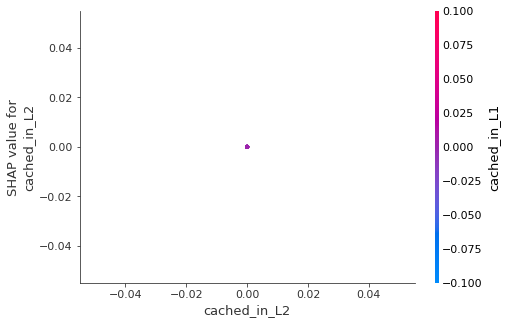

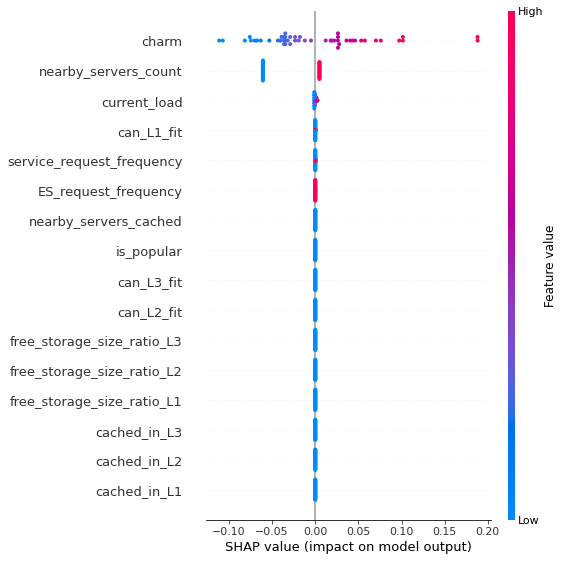

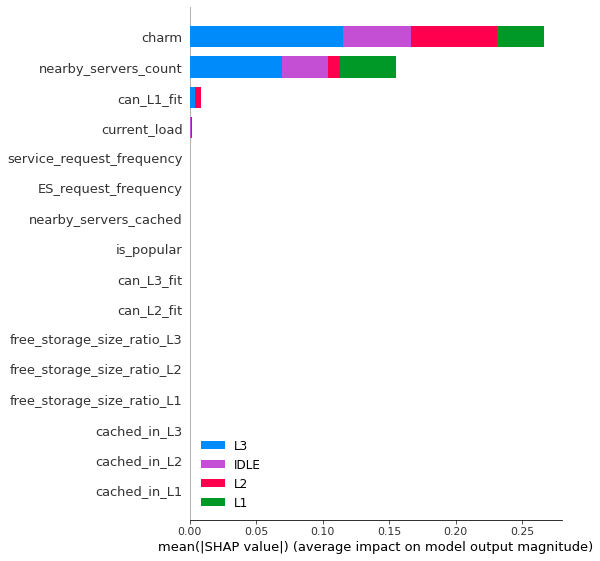

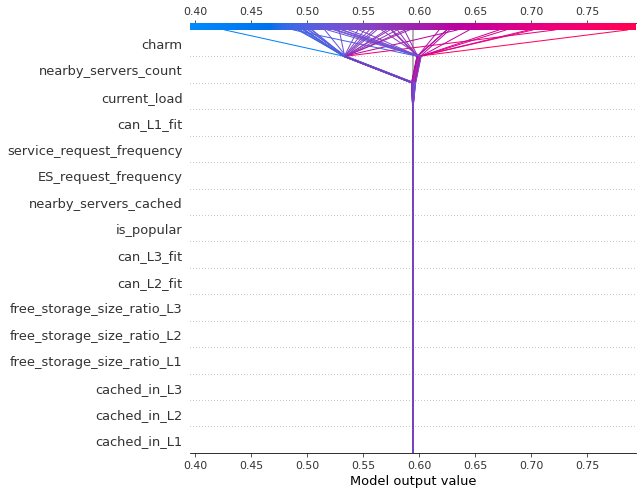

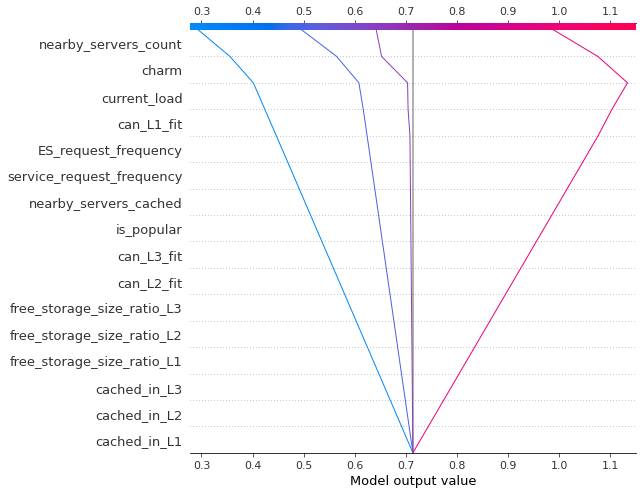

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 720x216 with 0 Axes>

In [6]:
# Plots
class_index = 0 #第几个动作
feature_index = 1 #观测到的第几个特征
shap.dependence_plot(feature_names[feature_index], shap_values[class_index], x, feature_names, interaction_index=feature_names[0])
shap.summary_plot(shap_values[class_index], x, feature_names,class_names=cache_agent.actions)
shap.summary_plot(shap_values, x, feature_names,class_names=cache_agent.actions)
shap.decision_plot(explainer.expected_value[class_index], shap_values[class_index], feature_names)
shap.multioutput_decision_plot(list(explainer.expected_value), shap_values,row_index=feature_index,feature_names=feature_names)
shap.monitoring_plot(feature_index,shap_values[class_index],x, feature_names)

#shap.partial_dependence_plot(0, agent.q_target, data)
#shap.bar_plot(shap_values[sample_index],x,feature_names)
#shap.waterfall_plot(shap_exp)
#shap.group_difference_plot(shap_values[sample_index], x, feature_names)

shap.force_plot(explainer.expected_value[class_index], shap_values[class_index], feature_names)
#shap.force_plot(explainer.expected_value[sample_index], shap_values[sample_index][idx], masker.data[idx])